## author: Keer Mei
- github: kmei92
- email: keer.mei18@imperial.ac.uk

# Setup

In [1]:
# importing the necessary modules
import sys
sys.path.append("..")
from fireframe.PDESystem import *
from fireframe.PDESubsystem import *
from fireframe.pdeforms import *

%load_ext autoreload
%autoreload 2

# Description:

This demonstration solves the three chemicals first order reaction mass balance equations coupled to the incompressible Navier Stokes equation and continuity equation. The mass balance for the three chemicals are given as:

$$\frac{\partial c_1}{\partial t} + u\cdot\nabla c_1 - \nabla\cdot{(D\nabla c_1)} = f_1 - Kc_1c_2 , $$
$$\frac{\partial c_2}{\partial t} + u\cdot\nabla c_2 - \nabla\cdot{(D\nabla c_2)} = f_2 - Kc_1c_2 , $$
$$\frac{\partial c_3}{\partial t} + u\cdot\nabla c_3 - \nabla\cdot{(D\nabla c_3)} = f_3 + Kc_1c_2 - Kc_3.$$

# Variational forms

The variational form for the Navier Stokes equation is given in fireframe.pdeforms.navier_stokes. The variational form for the chemicals mass balance is given in:
- fireframe.pdeforms.reactions (nonlinear form with all three chemicals coupled)
- fireframe.pdeforms.reactions_uncoupled (linear form of each chemical mass balance)

# Creating pde_solver, a child object from PDESystem

In [2]:
# a PDESystem child class called PDESolver. Note, the setup_constants function and setup_bcs are declared
# and overloaded here and the PDESystem's functions are not used. This is designed for clarity
class pde_solver(PDESystem):
    def __init__(self, comp, mesh, parameters):
        PDESystem.__init__(self, comp, mesh, parameters)

    def setup_bcs(self):
        x, y = fd.SpatialCoordinate(self.mesh)

        bcu = [fd.DirichletBC(self.V['u'], fd.Constant((0,0)), (1, 4)), # top-bottom and cylinder no slip
            fd.DirichletBC(self.V['u'], ((4.0*1.5*y*(0.41 - y) / 0.41**2) ,0), 2)] # inflow
        bcp = [fd.DirichletBC(self.V['p'], fd.Constant(0), 3)]  # outflow

        self.bc['u'][0] = [bcu, None, None, None,'fixed'] # static boundary
        self.bc['p'] = [[bcp, None, None, None, 'fixed']] # static boundary
        
    def setup_constants(self):
        x, y = fd.SpatialCoordinate(self.mesh)
        self.constants = {
            'deltat' : fd.Constant(self.prm['dt']), # time step
            'n' : fd.FacetNormal(self.mesh), # normal direction
            'f' : fd.Constant((0.0, 0.0)), # body force
            'nu' : fd.Constant(0.001), # fluid viscosity
            'eps' : fd.Constant(0.01), # diffusive coefficient
            'K' : fd.Constant(10.0), # reaction coefficient
            'f_1' : fd.conditional(pow(x-0.1, 2)+pow(y-0.1,2)<0.05*0.05, 0.1, 0), # source term chemical 1
            'f_2' : fd.conditional(pow(x-0.1, 2)+pow(y-0.3,2)<0.05*0.05, 0.1, 0), # source term chemical 2
            'f_3' : fd.Constant(0.0) # source term chemical 3
        }

# Solve

In [3]:
import time

# update the parameters. note, pressure p is not defined here because it uses all default values
solver_parameters = recursive_update(solver_parameters,
{
'space': {'u': fd.VectorFunctionSpace, 'c' : fd.MixedFunctionSpace},
'degree': {'u': 2 },
'order' : {'c' : 3},
'ksp_type': {'u': 'gmres', 'p': 'gmres', 'c':'gmres'},
'precond': {'u': 'sor', 'p' : 'sor', 'c':'sor'},
'dt' : 0.0005,
 'T' : 1.0 }                         
)

# Testing speed vs. spatial refinement
solve_time = []
for i in range(1, 6):
    # load the mesh
    mesh = fd.Mesh("../meshes/cylinder%d.msh" % i) 
    # declare a new pde_solver object with a velocity and pressure variable
    solver = pde_solver([['u', 'p']], mesh, solver_parameters)
    # add a concentration system to the pde_solver object
    solver.add_subsystem('c', solver_parameters)
    # set up constants
    solver.setup_constants()
    # define the pdesystems and variable sequence
    solver.define(['u', 'p', 'u'], 'up', navier_stokes)
    solver.define(['c'], 'c', reactions)
    # setup boundary conditions
    solver.setup_bcs()
    # solve
    start = time.clock()
    solver.solve()
    end = time.clock()
    print('total time: ', end-start)
    solve_time.append(end-start)

time = 1.000
total time:  309.724829
time = 1.000
total time:  323.775614
time = 1.000
total time:  372.4805819999999
time = 1.000
total time:  440.15694900000005
time = 1.000
total time:  723.6344409999999


# Plotting

(-0.11000000000000006,
 2.310000000000001,
 -0.020500000000000004,
 0.43050000000000005)

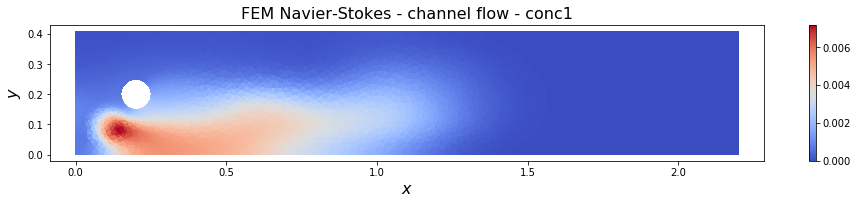

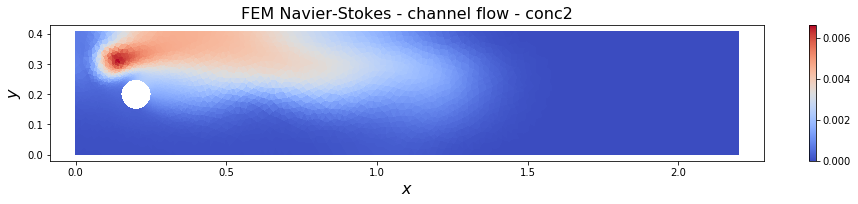

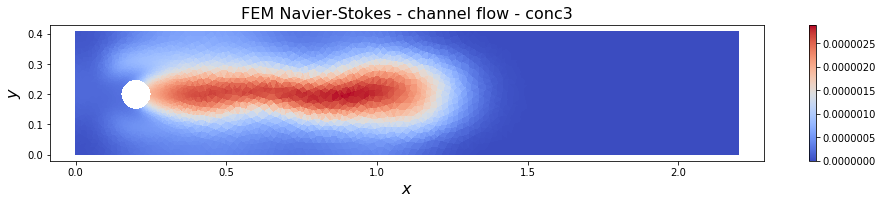

In [4]:
# since c is a mixedfunctionspace variable, use firedrake's split function to retrieve each
# subcomponent
c1, c2, c3 = solver.form_args['c_'].split()

fig4 = plt.figure(figsize=(16, 2.5))
ax4 = fig4.add_subplot(111)
ax4.set_xlabel('$x$', fontsize=16)
ax4.set_ylabel('$y$', fontsize=16)
ax4.set_title('FEM Navier-Stokes - channel flow - conc1', fontsize=16)
fd.plot(c1,axes=ax4)
ax4.axis('equal')

fig5 = plt.figure(figsize=(16, 2.5))
ax5 = fig5.add_subplot(111)
ax5.set_xlabel('$x$', fontsize=16)
ax5.set_ylabel('$y$', fontsize=16)
ax5.set_title('FEM Navier-Stokes - channel flow - conc2', fontsize=16)
fd.plot(c2,axes=ax5)
ax5.axis('equal')

fig6 = plt.figure(figsize=(16, 2.5))
ax6 = fig6.add_subplot(111)
ax6.set_xlabel('$x$', fontsize=16)
ax6.set_ylabel('$y$', fontsize=16)
ax6.set_title('FEM Navier-Stokes - channel flow - conc3', fontsize=16)
fd.plot(c3,axes=ax6)
ax6.axis('equal')

## Uncoupled Reactions

In [5]:
# update the parameters, here since the new PDESystem is a series of uncoupled reaction equations,
# we have replaced the variable 'c' with 'c1', 'c2', and 'c3' to represent each subcomponent
solver_parameters = recursive_update(solver_parameters,
{
'space': {'u': fd.VectorFunctionSpace, 'c1': fd.FunctionSpace, 'c2' :fd.FunctionSpace, 'c3':fd.FunctionSpace},
'degree': {'u': 2},
'ksp_type': {'u': 'gmres', 'p': 'gmres', 'c1': 'gmres','c2': 'gmres','c3': 'gmres'},
'subsystem_class' : {'up' : navier_stokes, 'c1c2c3' : reactions_uncoupled}, #also a new system is declared
'precond': {'u': 'sor', 'p' : 'sor', 'c1': 'sor','c2': 'sor','c3': 'sor'},
'dt' : 0.0005,
 'T' : 1.0 }                         
)

# Testing speed vs. spatial refinement
uncoupled_solve_time = []
total_vertices = []
for i in range(1, 6):
    # load the mesh
    mesh = fd.Mesh("../meshes/cylinder%d.msh" % i) 
    # declare a new pde_solver object with a velocity and pressure variable
    solver = pde_solver([['u', 'p']], mesh, solver_parameters)
    # add a concentration system to the pde_solver object
    solver.add_subsystem(['c1', 'c2', 'c3'], solver_parameters)
    # set up constants
    solver.setup_constants()
    # define the pdesystems
    solver.define(['u', 'p', 'u'], 'up', navier_stokes)
    solver.define(['c1', 'c2', 'c3'], 'c1c2c3', reactions_uncoupled)
    # setup boundary conditions
    solver.setup_bcs()
     # solve
    start = time.clock()
    solver.solve()
    end = time.clock()
    print('total time: ', end-start)
    uncoupled_solve_time.append(end-start)
    total_vertices.append(mesh.num_vertices())

time = 1.000
total time:  252.95807999999988
time = 1.000
total time:  214.98057999999992
time = 1.000
total time:  218.20037999999977
time = 1.000
total time:  270.6410900000001
time = 1.000
total time:  680.9248229999998


(-0.11000000000000006,
 2.310000000000001,
 -0.020500000000000004,
 0.43050000000000005)

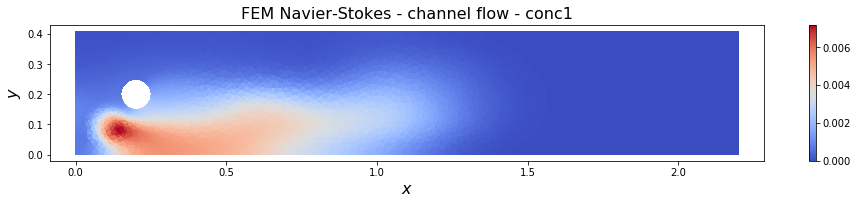

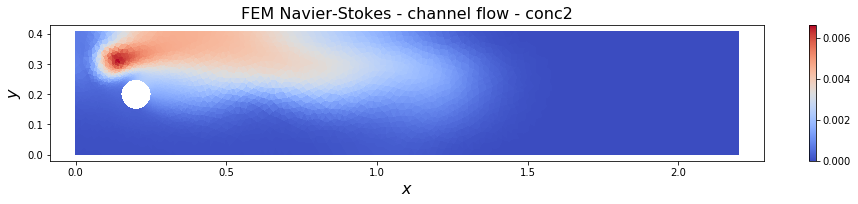

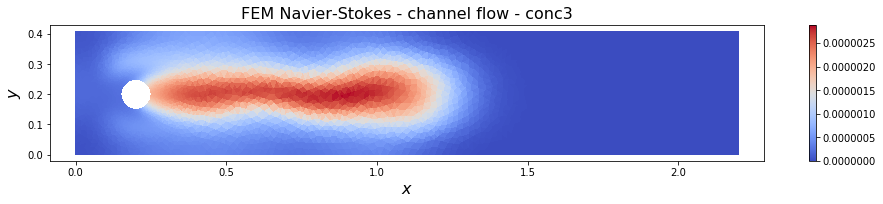

In [6]:
# no longer need to split the variable 'c' since there are three separate variables to represent
# each chemical species
fig4 = plt.figure(figsize=(16, 2.5))
ax4 = fig4.add_subplot(111)
ax4.set_xlabel('$x$', fontsize=16)
ax4.set_ylabel('$y$', fontsize=16)
ax4.set_title('FEM Navier-Stokes - channel flow - conc1', fontsize=16)
fd.plot(solver.form_args['c1_'],axes=ax4)
ax4.axis('equal')

fig5 = plt.figure(figsize=(16, 2.5))
ax5 = fig5.add_subplot(111)
ax5.set_xlabel('$x$', fontsize=16)
ax5.set_ylabel('$y$', fontsize=16)
ax5.set_title('FEM Navier-Stokes - channel flow - conc2', fontsize=16)
fd.plot(solver.form_args['c2_'],axes=ax5)
ax5.axis('equal')

fig6 = plt.figure(figsize=(16, 2.5))
ax6 = fig6.add_subplot(111)
ax6.set_xlabel('$x$', fontsize=16)
ax6.set_ylabel('$y$', fontsize=16)
ax6.set_title('FEM Navier-Stokes - channel flow - conc3', fontsize=16)
fd.plot(solver.form_args['c3_'],axes=ax6)
ax6.axis('equal')

## Plotting coupled vs uncoupled reaction solve times

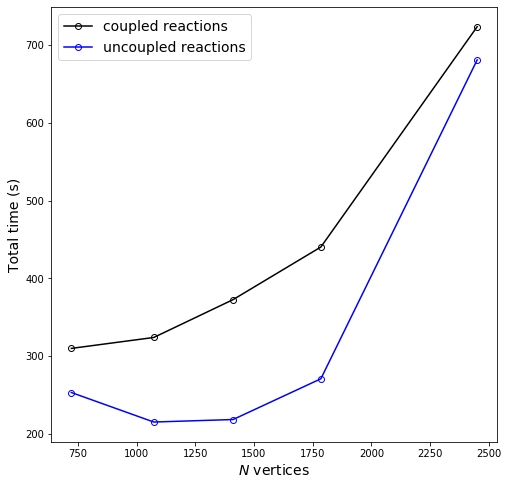

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))
# plot error map

ax1.plot(total_vertices, solve_time, 'o-', label='coupled reactions', color='k', markerfacecolor='None')
ax1.plot(total_vertices, uncoupled_solve_time, 'o-', label='uncoupled reactions', color='b', markerfacecolor='None')

ax1.set_xlabel('$N$ vertices', fontsize=14)
ax1.set_ylabel('Total time (s)', fontsize=14)
# ax1.set_title('Error convergence graph vs. $\Delta t$', fontsize=14)
ax1.legend(loc='best', fontsize=14)

### Solve for a final time of 5

In [ ]:
solver_parameters = recursive_update(solver_parameters,
{
'space': {'u': fd.VectorFunctionSpace, 'c1': fd.FunctionSpace, 'c2' :fd.FunctionSpace, 'c3':fd.FunctionSpace},
'degree': {'u': 2},
'ksp_type': {'u': 'gmres', 'p': 'gmres', 'c1': 'gmres','c2': 'gmres','c3': 'gmres'},
'precond': {'u': 'sor', 'p' : 'sor', 'c1': 'sor','c2': 'sor','c3': 'sor'},
'dt' : 0.001,
 'T' : 5.0 }                         
)

# load the mesh
mesh = fd.Mesh("../meshes/cylinder5.msh") 
# declare a new pde_solver object with a velocity and pressure variable
solver = pde_solver([['u', 'p']], mesh, solver_parameters)
# add a concentration system to the pde_solver object
solver.add_subsystem(['c1', 'c2', 'c3'], solver_parameters)
# set up constants
solver.setup_constants()
# define the pdesystems
solver.define(['u', 'p', 'u'], 'up', navier_stokes)
solver.define(['c1', 'c2', 'c3'], 'c1c2c3', reactions_uncoupled)
# setup boundary conditions
solver.setup_bcs()
 # solve
solver.solve()

In [ ]:
fig4 = plt.figure(figsize=(16, 2.5))
ax4 = fig4.add_subplot(111)
ax4.set_xlabel('$x$', fontsize=16)
ax4.set_ylabel('$y$', fontsize=16)
ax4.set_title('FEM Navier-Stokes - channel flow - conc1', fontsize=16)
fd.plot(solver.form_args['c1_'],axes=ax4)
ax4.axis('equal')

fig5 = plt.figure(figsize=(16, 2.5))
ax5 = fig5.add_subplot(111)
ax5.set_xlabel('$x$', fontsize=16)
ax5.set_ylabel('$y$', fontsize=16)
ax5.set_title('FEM Navier-Stokes - channel flow - conc2', fontsize=16)
fd.plot(solver.form_args['c2_'],axes=ax5)
ax5.axis('equal')

fig6 = plt.figure(figsize=(16, 2.5))
ax6 = fig6.add_subplot(111)
ax6.set_xlabel('$x$', fontsize=16)
ax6.set_ylabel('$y$', fontsize=16)
ax6.set_title('FEM Navier-Stokes - channel flow - conc3', fontsize=16)
fd.plot(solver.form_args['c3_'],axes=ax6)
ax6.axis('equal')